In [137]:

import torch

import numpy as np
import open_clip
from open_clip import tokenizer

import random

random.seed(33)

In [148]:
path2text = './general.txt'

prompts_list = []

with open(path2text, 'r') as f:
    for line in f:
        prompts_list.append(line.strip())


In [149]:
print(prompts_list[:10])

['A futuristic cityscape with flying cars, neon lights, and towering skyscrapers.', 'A mystical forest with a majestic unicorn standing in a clearing, surrounded by glowing flowers.', 'A vibrant underwater world with colorful coral reefs, schools of tropical fish, and a mermaid swimming by.', 'An otherworldly landscape with floating islands, strange rock formations, and a massive portal in the sky.', 'A bustling market in a foreign city, filled with exotic spices, fruits, and handcrafted goods.', 'A dramatic space battle between a fleet of starships and a massive alien mothership, with laser beams and explosions lighting up the scene.', 'A serene mountain landscape with a tranquil lake, towering pine trees, and a small cabin nestled in the woods.', 'A romantic scene with a couple dancing in a moonlit garden, surrounded by blooming flowers and twinkling stars.', 'A post-apocalyptic wasteland with ruins of buildings, abandoned vehicles, and survivors scavenging for resources.', 'A glamor

In [150]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', )

In [151]:
text_tokens = tokenizer.tokenize(prompts_list)
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()

In [183]:
# comput cosine similarity
cos_sim = np.dot(text_features, text_features.T) / (np.linalg.norm(text_features, axis=1)[:, None] * np.linalg.norm(text_features, axis=1)[None, :])
# delete the diagonal entries from the matrix
for i in range(len(cos_sim)):
    cos_sim[i][i] = 1.0

# find the most similar prompts with thresh and remove them
thresh = 0.8

# shuffle indices
indices = list(range(len(prompts_list)))
random.shuffle(indices)

visited = set()
for i in indices:
    for j in indices:
        if i == j or j < i:
            continue

        if cos_sim[i][j] > thresh:
            visited.add(j)

new_indices = []
for i in indices:
    if i not in visited:
        new_indices.append(i)

new_cos_sim = np.zeros((len(new_indices), len(new_indices)))
for i in range(len(new_indices)):
    for j in range(len(new_indices)):
        new_cos_sim[i][j] = cos_sim[new_indices[i]][new_indices[j]]

print(new_cos_sim.shape)

(78, 78)


In [186]:
# find the closest text prompts using cosine similarity
top_k = 2
closest_ids = new_cos_sim.argsort(axis=1)[:, -top_k:][:, ::-1]

for prompt, closest_id in zip(prompts_list, closest_ids):
    print(prompt)
    for idx in closest_id[1:]: # exclude the first one, which is the prompt itself
        print(prompts_list[idx])
    break

A futuristic cityscape with flying cars, neon lights, and towering skyscrapers.
A dramatic historical battle scene with armies clashing on a field, weapons and armor glinting in the sunlight.


In [187]:
from sklearn.cluster import KMeans

k = 10

distance_matrix = new_cos_sim

# k-means clustering
# finds the closest point to the centroid of each cluster
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=33, n_init=100, max_iter=1000)
kmeans.fit(distance_matrix)

centroids = kmeans.cluster_centers_

k_points = []
for i in range(k):
    # find the closest point to the centroid of each cluster
    # that ensures that points will be spread out
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    closest_point = cluster_indices[np.argmin(distance_matrix[cluster_indices][:, cluster_indices].sum(axis=0))]
    k_points.append(closest_point)

print(k_points)

[15, 20, 39, 32, 4, 0, 68, 70, 17, 8]


In [188]:
temp = new_cos_sim[k_points, :][:, k_points]
temp = temp - np.eye(temp.shape[0])

dissimilarity_coef = (temp.sum() // 2) / (temp.shape[0] * (temp.shape[0] - 1) / 2)
print(f"Mean distance, i.e. cosine similarity, is {round(dissimilarity_coef, 4)}")

Mean distance, i.e. cosine similarity, is 0.4


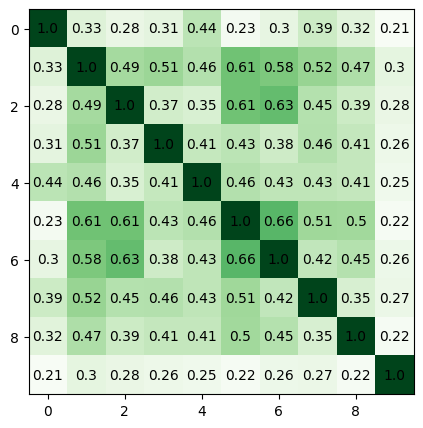

In [191]:
# distance between the most dissimilar prompts
# plot it color coded as a heatmap
import matplotlib.pyplot as plt



plt.figure(figsize=(5, 5))
plt.imshow(distance_matrix[k_points, :][:, k_points], cmap='Greens', interpolation='nearest')
# put values in the cells
for i in range(k):
    for j in range(k):
        plt.text(j, i, round(distance_matrix[k_points[i]][k_points[j]], 2), ha='center', va='center', color='black')
plt.show()


In [192]:
# Most dissimilar prompts
for idx in k_points:
    print(prompts_list[idx])

A romantic scene with a couple sitting on a park bench, surrounded by autumn leaves and a beautiful sunset.
A retro-futuristic cityscape with flying cars, rocket ships, and towering skyscrapers adorned with neon lights and holographic advertisements.
A cozy cabin in the woods scene with a warm fire, hot cocoa, and a group of friends snuggled up with blankets, reading books and telling stories.
A thrilling fantasy battle with dragons, wizards, and knights clashing swords in a field of fire.
A bustling market in a foreign city, filled with exotic spices, fruits, and handcrafted goods.
A futuristic cityscape with flying cars, neon lights, and towering skyscrapers.
A thrilling and suspenseful spy scene with secret agents, hidden microphones, and a high-stakes mission to uncover a conspiracy.
A post-apocalyptic city scene with crumbling buildings, scavengers, and mutated creatures roaming the streets.
A mysterious scene with an ancient temple hidden deep in a jungle, with vines and moss cov

In [193]:
# find the index of the maximum value in the matrix temp
i, j = np.unravel_index(np.argmax(temp), temp.shape)
print(f"Most similar prompts are: \n{prompts_list[k_points[i]]} \n{prompts_list[k_points[j]]}")


Most similar prompts are: 
A futuristic cityscape with flying cars, neon lights, and towering skyscrapers. 
A thrilling and suspenseful spy scene with secret agents, hidden microphones, and a high-stakes mission to uncover a conspiracy.
